In [2]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=14f7eb632e960e79170a3d27660822d1dfb9f7effd205379bb98b90035867d3d
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import time

In [4]:
# Create a Spark session
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

In [104]:
from google.colab import files

# Upload the CSV file
uploaded = files.upload()

Saving 6kdata.csv to 6kdata.csv


In [107]:
# Load the CSV file into a Spark DataFrame
start_time = time.time()
df = spark.read.option("header", "true").csv("6kdata.csv")

In [108]:
# Assuming 'df' is your PySpark DataFrame
num_data_points = df.count()

print(f"Number of data points: {num_data_points}")

Number of data points: 5999


In [109]:
# Filter the 'Sentiment' column values to only include 'Neutral', 'Negative', 'Positive'
allowed_sentiments = ['Neutral', 'Negative', 'Positive']
df = df.filter(df["Sentiment"].isin(allowed_sentiments))

In [110]:
# Tokenization
tokenizer = Tokenizer(inputCol="Review", outputCol="words")
words_data = tokenizer.transform(df)

In [111]:
# TF
hashing_tf = HashingTF(inputCol="words", outputCol="rawFeatures")
featurized_data = hashing_tf.transform(words_data)

In [112]:
# IDF
idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized_data)
rescaled_data = idf_model.transform(featurized_data)

In [113]:
# Convert string labels into numerical indices
indexer = StringIndexer(inputCol="Sentiment", outputCol="label")
indexed_data = indexer.fit(rescaled_data).transform(rescaled_data)

In [114]:
# Split the data into training and test sets
(train_data, test_data) = indexed_data.randomSplit([0.8, 0.2], seed=123)

In [115]:
# Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10)
# Pipeline
pipeline = Pipeline(stages=[lr])

In [116]:
# Train the model
start_training_time = time.time()
model = pipeline.fit(train_data)
end_training_time = time.time()

In [117]:
# Make predictions on the test set
start_prediction_time = time.time()
predictions = model.transform(test_data)
end_prediction_time = time.time()
# Show the predictions
predictions.select("Review", "Sentiment", "prediction").show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+----------+
|Review                                                                                                                                                                                                                                                                      |Sentiment|prediction|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+----------+
|A giant wet mess , far less appealing in person .                                                                          

In [118]:
print(f"Total time for loading and preprocessing: {end_training_time - start_time} seconds")
print(f"Total time for training the model: {end_training_time - start_training_time} seconds")
print(f"Total time for making predictions: {end_prediction_time - start_prediction_time} seconds")


Total time for loading and preprocessing: 60.539050340652466 seconds
Total time for training the model: 8.831965923309326 seconds
Total time for making predictions: 0.05376458168029785 seconds


In [119]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate accuracy
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator_accuracy.evaluate(predictions)

# Evaluate precision
evaluator_precision = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedPrecision"
)
precision = evaluator_precision.evaluate(predictions)

# Evaluate recall
evaluator_recall = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedRecall"
)
recall = evaluator_recall.evaluate(predictions)

# Evaluate F1 score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1"
)
f1_score = evaluator_f1.evaluate(predictions)

# Print the evaluation metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1_score * 100:.2f}%")


Accuracy: 94.86%
Precision: 94.98%
Recall: 94.86%
F1 Score: 94.89%


In [120]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Convert the DataFrame to an RDD for using MulticlassMetrics
predictionAndLabels = predictions.select("prediction", "label").rdd

# Create a MulticlassMetrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Confusion matrix
confusion_matrix = metrics.confusionMatrix()


In [122]:
print("Confusion Matrix:")
print(confusion_matrix)

Confusion Matrix:
[[433.  11.  10.]
 [  5. 204.  10.]
 [  4.   4. 175.]]


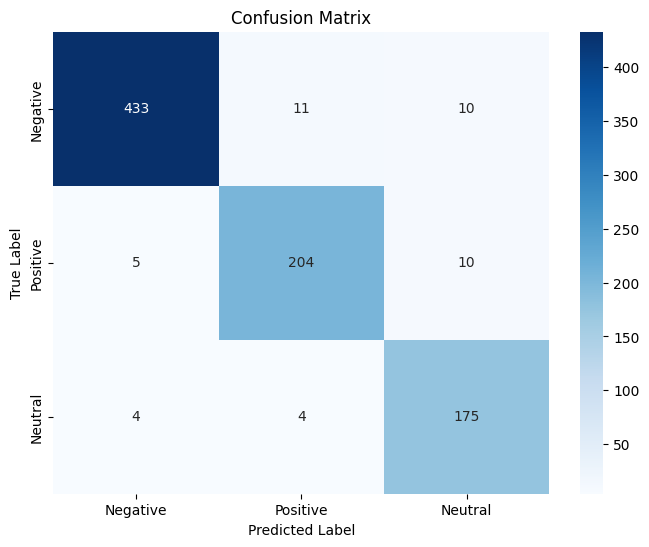

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.mllib.evaluation import MulticlassMetrics

# ... (your existing code for model training and prediction)

# Convert the DataFrame to an RDD for using MulticlassMetrics
predictionAndLabels = predictions.select("prediction", "label").rdd

# Create a MulticlassMetrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()

# Define class labels
class_labels = ["Negative", "Positive", "Neutral"]  # Replace with your actual class labels

# Plot the confusion matrix as a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels , yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
